In [1]:
import pandas as pd
import codecs
import numpy as np
import math
import csv
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import recall_score, precision_score # New
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import matplotlib.pyplot as plt
import openpyxl
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import matplotlib.dates as mdates
from keijzer import *
import math

In [2]:
data_path = 'C:/Users/smartgrid_AI/Desktop/windpower_ramprate/ercot_2020.csv'
data_source1 = pd.read_csv(data_path)
dat_source1 = pd.DataFrame(data_source1)
#dat_source1 = dat_source1.iloc[:-3,:]

data_path = 'C:/Users/smartgrid_AI/Desktop/windpower_ramprate/ercot_2021.csv'
data_source2 = pd.read_csv(data_path)
dat_source2 = pd.DataFrame(data_source2)
dat_source2 = dat_source2.iloc[:8761,:9]

data_path = 'C:/Users/smartgrid_AI/Desktop/windpower_ramprate/ercot_2022.csv'
data_source3 = pd.read_csv(data_path)
dat_source3 = pd.DataFrame(data_source3)
dat_source3 = dat_source3.iloc[:8760,:9]

data_path = 'C:/Users/smartgrid_AI/Desktop/windpower_ramprate/ercot_2023.csv'
data_source4 = pd.read_csv(data_path)
dat_source4 = pd.DataFrame(data_source4)
dat_source4 = dat_source4.iloc[:8760,:9]

dat_arr1 = np.array(dat_source1)
dat_arr2 = np.array(dat_source2)
dat_arr3 = np.array(dat_source3)
dat_arr4 = np.array(dat_source4)

dat_arr = np.concatenate([dat_arr1, dat_arr2, dat_arr3, dat_arr4],axis=0)
dat_arr.shape # 8784, 8761, 8760, 8760

dat_source = pd.DataFrame(dat_arr, columns=['Time-Date stamp','Date','ERCOT Load','Total Wind Output','Total Wind Installed','Wind Output, % of Load','Wind Output, % of Installed','1-hr MW change','1-hr % change'])
dat_source

,Time-Date stamp,Date,ERCOT Load,Total Wind Output,Total Wind Installed,"Wind Output, % of Load","Wind Output, % of Installed",1-hr MW change,1-hr % change
0,01-01-2020 00:00:00,Jan-01,36823,12335,27040,33.5,45.617,NaN,NaN
1,01-01-2020 01:00:00,Jan-01,36511,13300,27040,36.4,49.187,965.4,7.826
2,01-01-2020 02:00:00,Jan-01,36022,13586,27040,37.7,50.245,286.2,2.152
3,01-01-2020 03:00:00,Jan-01,35790,14107,27040,39.4,52.171,520.9,3.834
4,01-01-2020 04:00:00,Jan-01,35642,14887,27040,41.8,55.055,779.6,5.527
...,...,...,...,...,...,...,...,...,...
35060,12-31-2023 20:00:00,Dec-31,44887,17161,38631,38.23,44.42,2858,19.99
35061,12-31-2023 21:00:00,Dec-31,44013,18301,38631,41.58,47.37,1139,6.64
35062,12-31-2023 22:00:00,Dec-31,43280,18607,38631,42.99,48.17,307,1.67
35063,12-31-2023 23:00:00,Dec-31,42319,17866,38631,42.22,46.25,-741,-3.98


In [3]:
dat = pd.DataFrame()
dat['Timestamp'] = np.array(dat_source['Time-Date stamp'].iloc[1:])
dat['MW % change'] = np.array(dat_source.iloc[1:,3], dtype=float)-np.array(dat_source.iloc[0:-1,3], dtype=float)
dat['MW % change'] = np.divide(np.array(dat['MW % change']),np.array(dat_source.iloc[1:,4]))*100
dat['Total Wind Output'] = np.divide(np.array(dat_source.iloc[1:,3]), np.array(dat_source.iloc[1:,4]))

ramp_ratio = 20
load_ratio = 10
year_arr = np.concatenate([np.ones(8784)*2020, np.ones(8760)*2021, np.ones(8760)*2022, np.ones(8760)*2023])
year_df = pd.DataFrame(year_arr, columns=['Year'], dtype=int)
wind_df = pd.concat([year_df, dat], axis=1)
wind_df[-10:]

,Year,Timestamp,MW % change,Total Wind Output
35054,2023,12-31-2023 15:00:00,0.906008,0.224535
35055,2023,12-31-2023 16:00:00,1.3383,0.237918
35056,2023,12-31-2023 17:00:00,2.27279,0.260646
35057,2023,12-31-2023 18:00:00,2.26243,0.28327
35058,2023,12-31-2023 19:00:00,8.69768,0.370247
35059,2023,12-31-2023 20:00:00,7.3982,0.444229
35060,2023,12-31-2023 21:00:00,2.951,0.473739
35061,2023,12-31-2023 22:00:00,0.79211,0.48166
35062,2023,12-31-2023 23:00:00,-1.91815,0.462478
35063,2023,01-01-2024 00:00:00,-5.16942,0.410784


In [4]:
import sklearn

wind_df = wind_df.reset_index(drop=True)

std_scaler = sklearn.preprocessing.MinMaxScaler()
std_scaler_load = sklearn.preprocessing.MinMaxScaler()
std_scaler_ramp = sklearn.preprocessing.MinMaxScaler()

wind_df[['Total Wind Output']] = std_scaler.fit_transform(wind_df[['Total Wind Output']])
wind_df[['MW % change']] = std_scaler_ramp.fit_transform(wind_df[['MW % change']])
#wind_df[['Wind Change, % of Load', 'Wind Change']] = std_scaler_ramp.fit_transform(wind_df[['Wind Change, % of Load', 'Wind Change']])
wind_df = wind_df.iloc[:-1,:]
wind_df[-10:]

,Year,Timestamp,MW % change,Total Wind Output
35053,2023,12-31-2023 14:00:00,0.475470,0.281695
35054,2023,12-31-2023 15:00:00,0.540013,0.293595
35055,2023,12-31-2023 16:00:00,0.553030,0.311174
35056,2023,12-31-2023 17:00:00,0.581170,0.341026
35057,2023,12-31-2023 18:00:00,0.580858,0.370742
35058,2023,12-31-2023 19:00:00,0.774643,0.484984
35059,2023,12-31-2023 20:00:00,0.735512,0.582157
35060,2023,12-31-2023 21:00:00,0.601593,0.620917
35061,2023,12-31-2023 22:00:00,0.536583,0.631322
35062,2023,12-31-2023 23:00:00,0.454969,0.606127


In [5]:
dat_source1

,time-date stamp,Date,"ERCOT Load, MW","Total Wind Output, MW","Total Wind Installed, MW","Wind Output, % of Load","Wind Output, % of Installed",1-hr MW change,1-hr % change
0,01-01-2020 00:00:00,Jan-01,36823,12335,27040,33.5,45.617,NaN,NaN
1,01-01-2020 01:00:00,Jan-01,36511,13300,27040,36.4,49.187,965.4,7.826
2,01-01-2020 02:00:00,Jan-01,36022,13586,27040,37.7,50.245,286.2,2.152
3,01-01-2020 03:00:00,Jan-01,35790,14107,27040,39.4,52.171,520.9,3.834
4,01-01-2020 04:00:00,Jan-01,35642,14887,27040,41.8,55.055,779.6,5.527
...,...,...,...,...,...,...,...,...,...
8779,12-31-2020 19:00:00,Dec-31,49857,15165,31090,30.4,48.777,788.4,5.484
8780,12-31-2020 20:00:00,Dec-31,48800,15706,31090,32.2,50.517,540.8,3.566
8781,12-31-2020 21:00:00,Dec-31,47848,15079,31090,31.5,48.502,-626.4,-3.989
8782,12-31-2020 22:00:00,Dec-31,46123,14995,31090,32.5,48.231,-84.1,-0.558


In [6]:
data_path = 'C:/Users/smartgrid_AI/Documents/kms/windpower_ramprate/Different forecasting horizon/training_result_df_fh12.csv'
data_source1 = pd.read_csv(data_path)
dat_source1 = pd.DataFrame(data_source1)
dat_source1 = dat_source1.iloc[:,1:]
dat_source1.columns=["Predicted_Value", "Real_Value", "Forecasting_Error", "Initial_Predicted_Value"]

data_path = 'C:/Users/smartgrid_AI/Documents/kms/windpower_ramprate/Different forecasting horizon/training_ramp_result_df_fh12.csv'
data_source2 = pd.read_csv(data_path)
dat_source2 = pd.DataFrame(data_source2)
dat_source2 = dat_source2.iloc[:,1:]
dat_source2.columns=["Ramp_Predicted_Value", "Ramp_Real_Value", "Ramp_Forecasting_Error", "Ramp_Initial_Predicted_Value"]

dat_source = pd.concat([dat_source1, dat_source2], axis=1)
dat_source

,Predicted_Value,Real_Value,Forecasting_Error,Initial_Predicted_Value,Ramp_Predicted_Value,Ramp_Real_Value,Ramp_Forecasting_Error,Ramp_Initial_Predicted_Value
0,0.611590,0.642682,0.031092,0.642368,0.514047,0.491175,-0.022872,0.443332
1,0.630148,0.652422,0.022273,0.674968,0.552112,0.535059,-0.017053,0.453517
2,0.681963,0.685931,0.003968,0.695453,0.583013,0.589554,0.006542,0.455513
3,0.715735,0.693260,-0.022475,0.714938,0.534178,0.529532,-0.004646,0.439772
4,0.699694,0.680242,-0.019452,0.701029,0.563093,0.482885,-0.080208,0.419354
...,...,...,...,...,...,...,...,...
375175,0.517569,0.527118,0.009549,0.521190,0.528622,0.586502,0.057880,0.545282
375176,0.482051,0.497520,0.015469,0.536283,0.417284,0.444873,0.027589,0.530756
375177,0.483324,0.492569,0.009245,0.543520,0.476495,0.501380,0.024885,0.517517
375178,0.480938,0.508780,0.027842,0.521670,0.473842,0.549896,0.076054,0.357174


In [7]:
pred = np.array(dat_source[['Predicted_Value']])
rpred = np.array(dat_source[['Ramp_Predicted_Value']])

real_value = np.array(dat_source[['Predicted_Value']])+np.array(dat_source[['Forecasting_Error']])
real_ramp_value = np.array(dat_source[['Ramp_Predicted_Value']])+np.array(dat_source[['Ramp_Forecasting_Error']])

dat_source['Real_Value'] = real_value
dat_source['Initial_Forecasting_Error'] = real_value-np.array(dat_source[['Initial_Predicted_Value']])
dat_source['Real_Ramp_Value'] = real_ramp_value
dat_source['Ramp_Initial_Forecasting_Error'] = real_value-np.array(dat_source[['Ramp_Initial_Predicted_Value']])
dat_source

,Predicted_Value,Real_Value,Forecasting_Error,Initial_Predicted_Value,Ramp_Predicted_Value,Ramp_Real_Value,Ramp_Forecasting_Error,Ramp_Initial_Predicted_Value,Initial_Forecasting_Error,Real_Ramp_Value,Ramp_Initial_Forecasting_Error
0,0.611590,0.642682,0.031092,0.642368,0.514047,0.491175,-0.022872,0.443332,0.000315,0.491175,0.199350
1,0.630148,0.652422,0.022273,0.674968,0.552112,0.535059,-0.017053,0.453517,-0.022546,0.535059,0.198905
2,0.681963,0.685931,0.003968,0.695453,0.583013,0.589554,0.006542,0.455513,-0.009522,0.589554,0.230417
3,0.715735,0.693260,-0.022475,0.714938,0.534178,0.529532,-0.004646,0.439772,-0.021678,0.529532,0.253488
4,0.699694,0.680242,-0.019452,0.701029,0.563093,0.482885,-0.080208,0.419354,-0.020787,0.482885,0.260888
...,...,...,...,...,...,...,...,...,...,...,...
375175,0.517569,0.527118,0.009549,0.521190,0.528622,0.586502,0.057880,0.545282,0.005927,0.586502,-0.018164
375176,0.482051,0.497520,0.015469,0.536283,0.417284,0.444873,0.027589,0.530756,-0.038764,0.444873,-0.033237
375177,0.483324,0.492569,0.009245,0.543520,0.476495,0.501380,0.024885,0.517517,-0.050951,0.501380,-0.024948
375178,0.480938,0.508780,0.027842,0.521670,0.473842,0.549896,0.076054,0.357174,-0.012890,0.549896,0.151606


In [8]:
data_path = 'C:/Users/smartgrid_AI/Documents/kms/windpower_ramprate/Different forecasting horizon/test_result_df_fh12.csv'
data_source1 = pd.read_csv(data_path)
dat_source1 = pd.DataFrame(data_source1)
dat_source1 = dat_source1.iloc[:,1:]
dat_source1.columns=["Predicted_Value", "Real_Value", "Forecasting_Error", "Initial_Predicted_Value"]

data_path = 'C:/Users/smartgrid_AI/Documents/kms/windpower_ramprate/Different forecasting horizon/test_ramp_result_df_fh12.csv'
data_source2 = pd.read_csv(data_path)
dat_source2 = pd.DataFrame(data_source2)
dat_source2 = dat_source2.iloc[:,1:]
dat_source2.columns=["Ramp_Predicted_Value", "Ramp_Real_Value", "Ramp_Forecasting_Error", "Ramp_Initial_Predicted_Value"]

test_source = pd.concat([dat_source1, dat_source2], axis=1)
ini_test_source = pd.DataFrame(test_source)

pred = np.array(test_source[['Predicted_Value']])
rpred = np.array(test_source[['Ramp_Predicted_Value']])

real_value = np.array(test_source[['Predicted_Value']])+np.array(test_source[['Forecasting_Error']])
real_ramp_value = np.array(test_source[['Ramp_Predicted_Value']])+np.array(test_source[['Ramp_Forecasting_Error']])

test_source['Real_Value'] = real_value
test_source['Initial_Forecasting_Error'] = real_value-np.array(test_source[['Initial_Predicted_Value']])
test_source['Real_Ramp_Value'] = real_ramp_value
test_source['Ramp_Initial_Forecasting_Error'] = real_value-np.array(test_source[['Ramp_Initial_Predicted_Value']])
test_source

,Predicted_Value,Real_Value,Forecasting_Error,Initial_Predicted_Value,Ramp_Predicted_Value,Ramp_Real_Value,Ramp_Forecasting_Error,Ramp_Initial_Predicted_Value,Initial_Forecasting_Error,Real_Ramp_Value,Ramp_Initial_Forecasting_Error
0,0.614587,0.715967,0.101379,0.723591,0.846159,0.634218,-0.211941,0.721477,-0.007624,0.634218,-0.005510
1,0.573938,0.686438,0.112500,0.711232,0.646767,0.445033,-0.201734,0.624129,-0.024793,0.445033,0.062309
2,0.541589,0.641152,0.099563,0.670639,0.618651,0.408906,-0.209745,0.547076,-0.029487,0.408906,0.094077
3,0.479448,0.553299,0.073852,0.646805,0.492930,0.311316,-0.181613,0.564582,-0.093505,0.311316,-0.011282
4,0.441205,0.487758,0.046553,0.620697,0.488095,0.362469,-0.125626,0.524535,-0.132939,0.362469,-0.036777
...,...,...,...,...,...,...,...,...,...,...,...
40135,0.270835,0.293595,0.022760,0.551051,0.445168,0.540013,0.094844,0.355956,-0.257456,0.540013,-0.062361
40136,0.304273,0.311174,0.006900,0.569550,0.468389,0.553030,0.084641,0.335688,-0.258377,0.553030,-0.024515
40137,0.321500,0.341026,0.019526,0.594988,0.452008,0.581170,0.129163,0.289238,-0.253962,0.581170,0.051788
40138,0.367983,0.370742,0.002759,0.625949,0.544124,0.580858,0.036734,0.389270,-0.255206,0.580858,-0.018528


### Plotting Histograms

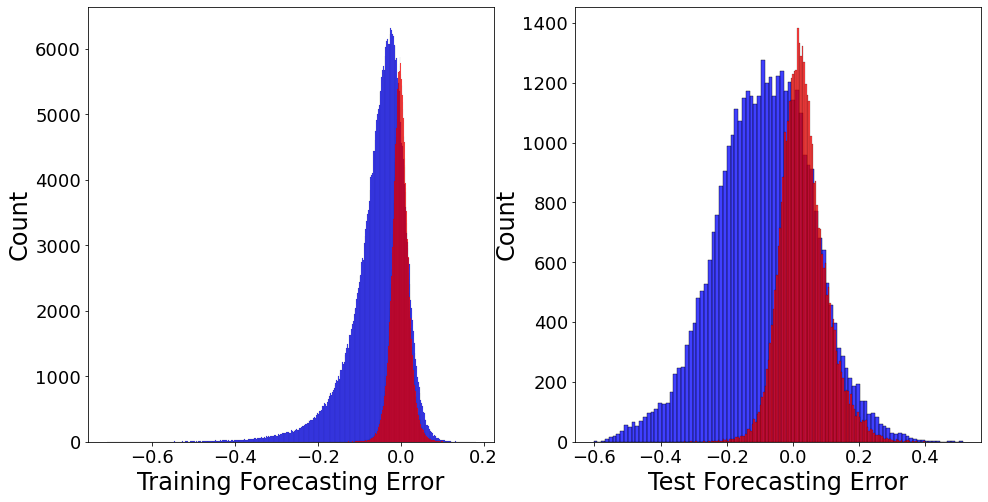

In [11]:
f, ax = plt.subplots(1, 2, figsize=(16, 8))
sns.histplot(data=dat_source, x="Initial_Forecasting_Error", color='blue', ax=ax[0])
sns.histplot(data=dat_source, x="Forecasting_Error", color='red', ax=ax[0])

sns.histplot(data=test_source, x="Initial_Forecasting_Error", color='blue', ax=ax[1])
sns.histplot(data=test_source, x="Forecasting_Error", color='red', ax=ax[1])

ax[0].tick_params(axis='both', which='major', labelsize=18)
ax[0].set_ylabel('Count', fontsize = "24")
a = ax[0].set_xlabel('Training Forecasting Error', fontsize = "24")
ax[1].tick_params(axis='both', which='major', labelsize=18)
ax[1].set_ylabel('Count', fontsize = "24")
a = ax[1].set_xlabel('Test Forecasting Error', fontsize = "24")

#f.savefig('GenError_Histogram_FFEL_lead.png', dpi=800, bbox_inches="tight")

In [12]:
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() #

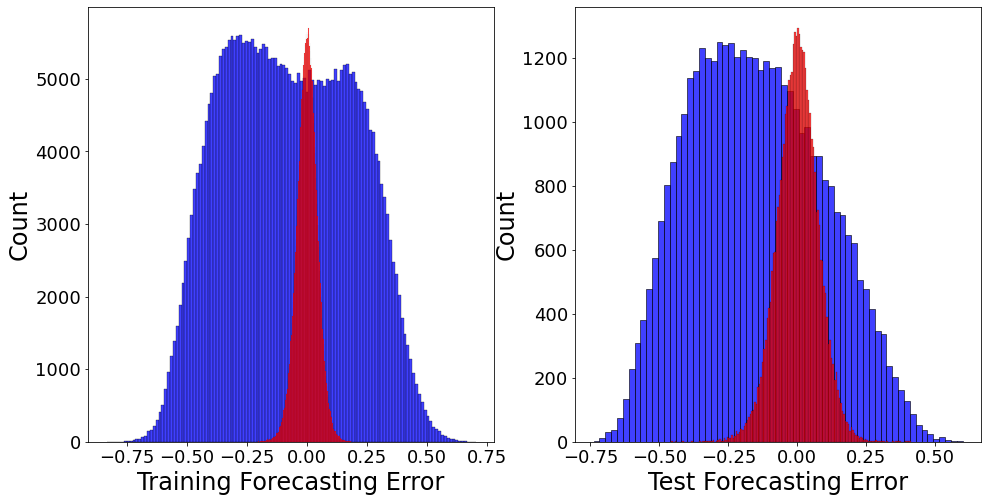

In [13]:
f, ax = plt.subplots(1, 2, figsize=(16, 8))
sns.histplot(data=dat_source, x="Ramp_Initial_Forecasting_Error", color='blue', ax=ax[0])
sns.histplot(data=dat_source, x="Ramp_Forecasting_Error", color='red', ax=ax[0])

sns.histplot(data=test_source, x="Ramp_Initial_Forecasting_Error", color='blue', ax=ax[1])
sns.histplot(data=test_source, x="Ramp_Forecasting_Error", color='red', ax=ax[1])

ax[0].tick_params(axis='both', which='major', labelsize=18)
ax[0].set_ylabel('Count', fontsize = "24")
a = ax[0].set_xlabel('Training Forecasting Error', fontsize = "24")
ax[1].tick_params(axis='both', which='major', labelsize=18)
ax[1].set_ylabel('Count', fontsize = "24")
a = ax[1].set_xlabel('Test Forecasting Error', fontsize = "24")

#f.savefig('RampError_Histogram_FFEL_lead.png', dpi=800, bbox_inches="tight")

In [14]:
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() #

## Training/Test Datset Construction

In [9]:
times = np.zeros(dat_source.shape[0], dtype=int)
for i in range(times.shape[0]):
    times[i] = int(i%24)

dat_source['time'] = times
dat_source

,Predicted_Value,Real_Value,Forecasting_Error,Initial_Predicted_Value,Ramp_Predicted_Value,Ramp_Real_Value,Ramp_Forecasting_Error,Ramp_Initial_Predicted_Value,Initial_Forecasting_Error,Real_Ramp_Value,Ramp_Initial_Forecasting_Error,time
0,0.611590,0.642682,0.031092,0.642368,0.514047,0.491175,-0.022872,0.443332,0.000315,0.491175,0.199350,0
1,0.630148,0.652422,0.022273,0.674968,0.552112,0.535059,-0.017053,0.453517,-0.022546,0.535059,0.198905,1
2,0.681963,0.685931,0.003968,0.695453,0.583013,0.589554,0.006542,0.455513,-0.009522,0.589554,0.230417,2
3,0.715735,0.693260,-0.022475,0.714938,0.534178,0.529532,-0.004646,0.439772,-0.021678,0.529532,0.253488,3
4,0.699694,0.680242,-0.019452,0.701029,0.563093,0.482885,-0.080208,0.419354,-0.020787,0.482885,0.260888,4
...,...,...,...,...,...,...,...,...,...,...,...,...
375175,0.517569,0.527118,0.009549,0.521190,0.528622,0.586502,0.057880,0.545282,0.005927,0.586502,-0.018164,7
375176,0.482051,0.497520,0.015469,0.536283,0.417284,0.444873,0.027589,0.530756,-0.038764,0.444873,-0.033237,8
375177,0.483324,0.492569,0.009245,0.543520,0.476495,0.501380,0.024885,0.517517,-0.050951,0.501380,-0.024948,9
375178,0.480938,0.508780,0.027842,0.521670,0.473842,0.549896,0.076054,0.357174,-0.012890,0.549896,0.151606,10


In [10]:
times = np.zeros(test_source.shape[0], dtype=int)
for i in range(times.shape[0]):
    times[i] = int(i%24)

test_source['time'] = times
test_source

,Predicted_Value,Real_Value,Forecasting_Error,Initial_Predicted_Value,Ramp_Predicted_Value,Ramp_Real_Value,Ramp_Forecasting_Error,Ramp_Initial_Predicted_Value,Initial_Forecasting_Error,Real_Ramp_Value,Ramp_Initial_Forecasting_Error,time
0,0.614587,0.715967,0.101379,0.723591,0.846159,0.634218,-0.211941,0.721477,-0.007624,0.634218,-0.005510,0
1,0.573938,0.686438,0.112500,0.711232,0.646767,0.445033,-0.201734,0.624129,-0.024793,0.445033,0.062309,1
2,0.541589,0.641152,0.099563,0.670639,0.618651,0.408906,-0.209745,0.547076,-0.029487,0.408906,0.094077,2
3,0.479448,0.553299,0.073852,0.646805,0.492930,0.311316,-0.181613,0.564582,-0.093505,0.311316,-0.011282,3
4,0.441205,0.487758,0.046553,0.620697,0.488095,0.362469,-0.125626,0.524535,-0.132939,0.362469,-0.036777,4
...,...,...,...,...,...,...,...,...,...,...,...,...
40135,0.270835,0.293595,0.022760,0.551051,0.445168,0.540013,0.094844,0.355956,-0.257456,0.540013,-0.062361,7
40136,0.304273,0.311174,0.006900,0.569550,0.468389,0.553030,0.084641,0.335688,-0.258377,0.553030,-0.024515,8
40137,0.321500,0.341026,0.019526,0.594988,0.452008,0.581170,0.129163,0.289238,-0.253962,0.581170,0.051788,9
40138,0.367983,0.370742,0.002759,0.625949,0.544124,0.580858,0.036734,0.389270,-0.255206,0.580858,-0.018528,10


In [11]:
dat_source

,Predicted_Value,Real_Value,Forecasting_Error,Initial_Predicted_Value,Ramp_Predicted_Value,Ramp_Real_Value,Ramp_Forecasting_Error,Ramp_Initial_Predicted_Value,Initial_Forecasting_Error,Real_Ramp_Value,Ramp_Initial_Forecasting_Error,time
0,0.611590,0.642682,0.031092,0.642368,0.514047,0.491175,-0.022872,0.443332,0.000315,0.491175,0.199350,0
1,0.630148,0.652422,0.022273,0.674968,0.552112,0.535059,-0.017053,0.453517,-0.022546,0.535059,0.198905,1
2,0.681963,0.685931,0.003968,0.695453,0.583013,0.589554,0.006542,0.455513,-0.009522,0.589554,0.230417,2
3,0.715735,0.693260,-0.022475,0.714938,0.534178,0.529532,-0.004646,0.439772,-0.021678,0.529532,0.253488,3
4,0.699694,0.680242,-0.019452,0.701029,0.563093,0.482885,-0.080208,0.419354,-0.020787,0.482885,0.260888,4
...,...,...,...,...,...,...,...,...,...,...,...,...
375175,0.517569,0.527118,0.009549,0.521190,0.528622,0.586502,0.057880,0.545282,0.005927,0.586502,-0.018164,7
375176,0.482051,0.497520,0.015469,0.536283,0.417284,0.444873,0.027589,0.530756,-0.038764,0.444873,-0.033237,8
375177,0.483324,0.492569,0.009245,0.543520,0.476495,0.501380,0.024885,0.517517,-0.050951,0.501380,-0.024948,9
375178,0.480938,0.508780,0.027842,0.521670,0.473842,0.549896,0.076054,0.357174,-0.012890,0.549896,0.151606,10


In [12]:
pair_ini_source = dat_source[['Initial_Predicted_Value', 'Initial_Forecasting_Error', 'Ramp_Initial_Predicted_Value', 'Ramp_Initial_Forecasting_Error', 'time']]

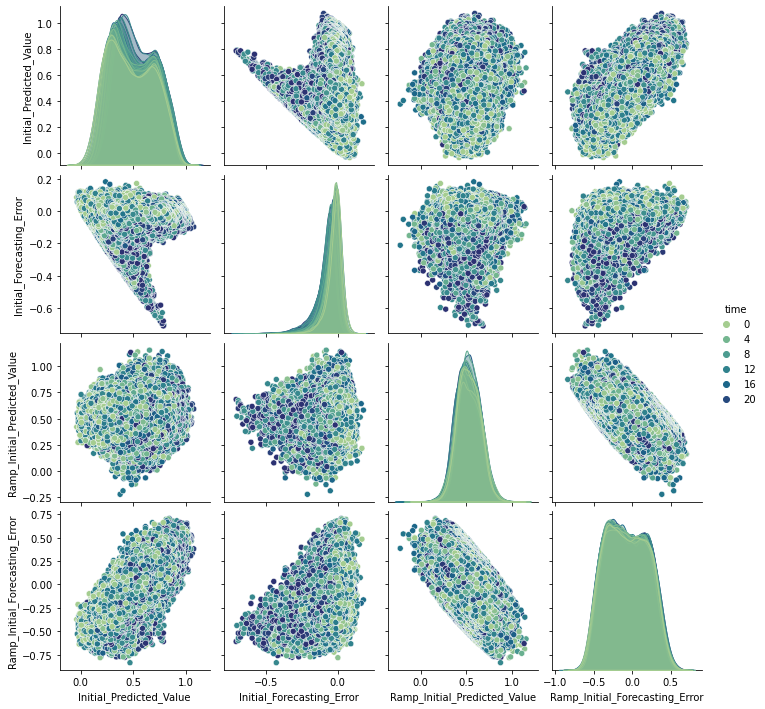

In [19]:
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() #

sns.pairplot(pair_ini_source, palette="crest", hue='time')
#plt.savefig('pairplot_ini_with_time_lead.png', dpi=1000, bbox_inches="tight")

In [20]:
pair_source = dat_source[['Predicted_Value', 'Forecasting_Error', 'Ramp_Predicted_Value', 'Ramp_Forecasting_Error', 'time']]

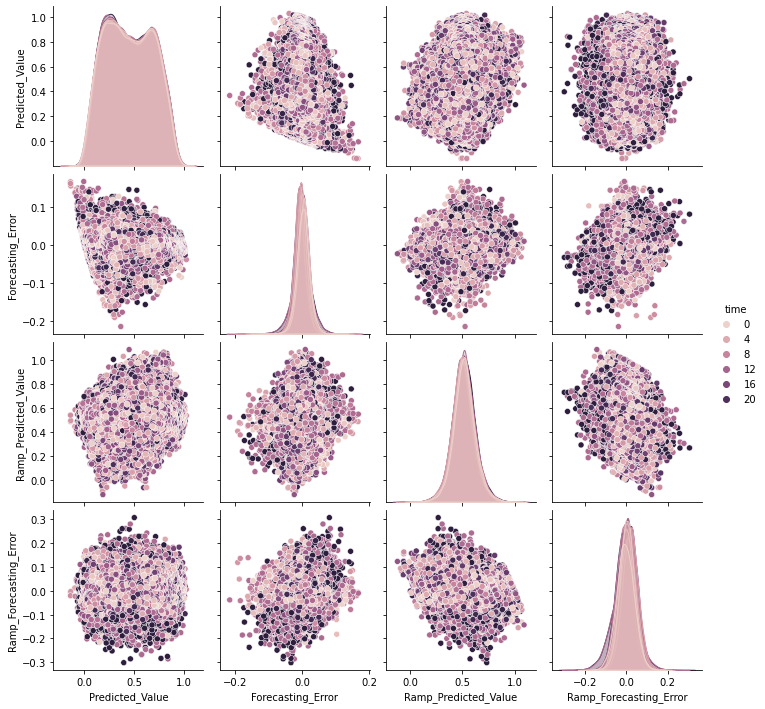

In [21]:
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() #

sns.pairplot(pair_source, hue='time')
#plt.savefig('pairplot_with_time_lead.png', dpi=1000, bbox_inches="tight")

In [12]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.square(y_true - y_pred))

def mae(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(abs(y_true - y_pred))

def maemd(y_true, y_pred):
    return np.mean((abs(y_pred - y_true))*np.square(y_true-np.mean(y_true)))*100

def maems(y_true, y_pred):
    return np.mean((abs(y_pred - y_true))*np.square(y_true))*100

In [13]:
tr_source = pd.DataFrame()
tr_source['Predicted_Value'] = dat_source['Predicted_Value']
tr_source['Real_Value'] = dat_source['Predicted_Value']+dat_source['Forecasting_Error']
tr_source['Ramp_Predicted_Value'] = dat_source['Ramp_Predicted_Value']
tr_source['Ramp_Real_Value'] = dat_source['Ramp_Predicted_Value']+dat_source['Ramp_Forecasting_Error']

times = np.zeros(tr_source.shape[0], dtype=int)
for i in range(times.shape[0]):
    times[i] = int(i%24)

tr_source['time'] = times
normtr_source = np.array(tr_source)
normtr_source

array([[ 0.61159027,  0.64268217,  0.51404685,  0.49117496,  0.        ],
       [ 0.63014841,  0.65242158,  0.55211198,  0.53505881,  1.        ],
       [ 0.68196261,  0.68593095,  0.58301282,  0.58955437,  2.        ],
       ...,
       [ 0.4833239 ,  0.49256926,  0.47649539,  0.5013805 ,  9.        ],
       [ 0.4809382 ,  0.50878022,  0.47384176,  0.54989562, 10.        ],
       [ 0.4481295 ,  0.4759051 ,  0.36857551,  0.43735972, 11.        ]])

In [14]:
tr_source[['Predicted_Value']] = std_scaler.inverse_transform(tr_source[['Predicted_Value']])
tr_source[['Real_Value']] = std_scaler.inverse_transform(tr_source[['Real_Value']])

tr_source[['Ramp_Predicted_Value']] = std_scaler_ramp.inverse_transform(tr_source[['Ramp_Predicted_Value']])
tr_source[['Ramp_Real_Value']] = std_scaler_ramp.inverse_transform(tr_source[['Ramp_Real_Value']])
tr_source

,Predicted_Value,Real_Value,Ramp_Predicted_Value,Ramp_Real_Value,time
0,0.466638,0.490309,0.043730,-0.715806,0
1,0.480767,0.497724,1.307809,0.741502,1
2,0.520215,0.523236,2.333974,2.551208,2
3,0.545927,0.528816,0.712237,0.557962,3
4,0.533714,0.518905,1.672459,-0.991117,4
...,...,...,...,...,...
375175,0.395055,0.402325,0.527732,2.449835,7
375176,0.368014,0.379791,-3.169602,-2.253424,8
375177,0.368983,0.376022,-1.203290,-0.376898,9
375178,0.367167,0.388364,-1.291413,1.234207,10


In [15]:
trgen_pred = np.array(tr_source['Predicted_Value']).reshape(-1,12)
trgen_real = np.array(tr_source['Real_Value']).reshape(-1,12)
trram_pred = np.array(tr_source['Ramp_Predicted_Value']).reshape(-1,12)
trram_real = np.array(tr_source['Ramp_Real_Value']).reshape(-1,12)

trng_pred = np.array(normtr_source[:,0]).reshape(-1,12)
trnr_pred = np.array(normtr_source[:,2]).reshape(-1,12)

In [16]:
tgram = np.zeros(trgen_pred.shape)

for i in range(tgram.shape[0]):
    for j in range(tgram.shape[1]):
        if (i==0) & (j==0):
            gen0 = trgen_real[0,0]-trram_real[0,0]/100
        elif j==0:
            gen0 = trgen_real[i-1,0]
        else:
            gen0 = trgen_pred[i,j-1]
        
        tgram[i,j] = (trgen_pred[i,j]-gen0)*100

### Reconstruction of Original Dataset

In [17]:
t_source = pd.DataFrame()

In [18]:
t_source['Predicted_Value'] = ini_test_source['Predicted_Value']
t_source['Real_Value'] = ini_test_source['Predicted_Value']+ini_test_source['Forecasting_Error']
t_source['Ramp_Predicted_Value'] = ini_test_source['Ramp_Predicted_Value']
t_source['Ramp_Real_Value'] = ini_test_source['Ramp_Predicted_Value']+ini_test_source['Ramp_Forecasting_Error']

times = np.zeros(ini_test_source.shape[0])
for i in range(times.shape[0]):
    times[i] = int(i%24)

t_source['time'] = times

In [19]:
normt_source = np.array(t_source)
normt_source

array([[ 0.61458719,  0.71596666,  0.84615898,  0.63421761,  0.        ],
       [ 0.57393819,  0.68643832,  0.64676672,  0.44503263,  1.        ],
       [ 0.5415889 ,  0.64115224,  0.61865056,  0.40890605,  2.        ],
       ...,
       [ 0.32149962,  0.34102591,  0.45200759,  0.58117028,  9.        ],
       [ 0.36798313,  0.37074228,  0.54412413,  0.58085847, 10.        ],
       [ 0.38775635,  0.48498374,  0.56687003,  0.77464268, 11.        ]])

In [20]:
t_source[['Predicted_Value']] = std_scaler.inverse_transform(t_source[['Predicted_Value']])
t_source[['Real_Value']] = std_scaler.inverse_transform(t_source[['Real_Value']])

t_source[['Ramp_Predicted_Value']] = std_scaler_ramp.inverse_transform(t_source[['Ramp_Predicted_Value']])
t_source[['Ramp_Real_Value']] = std_scaler_ramp.inverse_transform(t_source[['Ramp_Real_Value']])
t_source

,Predicted_Value,Real_Value,Ramp_Predicted_Value,Ramp_Real_Value,time
0,0.468919,0.546104,11.072614,4.034399,0.0
1,0.437971,0.523622,4.451133,-2.248116,1.0
2,0.413343,0.489144,3.517443,-3.447818,2.0
3,0.366032,0.422258,-0.657540,-6.688608,3.0
4,0.336916,0.372359,-0.818085,-4.989914,4.0
...,...,...,...,...,...
40135,0.207206,0.224535,-2.243615,0.906008,7.0
40136,0.232664,0.237918,-1.472491,1.338303,8.0
40137,0.245779,0.260646,-2.016489,2.272786,9.0
40138,0.281169,0.283270,1.042546,2.262432,10.0


## Combination of Two Forecasting Results

In [21]:
gen_pred = np.array(t_source['Predicted_Value']).reshape(-1,12)
gen_real = np.array(t_source['Real_Value']).reshape(-1,12)
ram_pred = np.array(t_source['Ramp_Predicted_Value']).reshape(-1,12)
ram_real = np.array(t_source['Ramp_Real_Value']).reshape(-1,12)

ng_pred = np.array(normt_source[:,0]).reshape(-1,12)
nr_pred = np.array(normt_source[:,2]).reshape(-1,12)

f_gen = np.zeros(gen_pred.shape)
f_ram = np.zeros(gen_pred.shape)

In [22]:
f_gen = np.zeros(gen_pred.shape)
f_ram = np.zeros(gen_pred.shape)

for i in range(gen_pred.shape[0]):    
    for j in range(gen_pred.shape[1]):
        if (i==0) & (j==0):
            gen0 = gen_real[0,0]-ram_real[0,0]/100
            
        elif j==0:
            gen0 = gen_real[i-1,0]
            
        else:
            gen0 = f_gen[i,j-1]
        
        if ((nr_pred[i,j]<0.2)) | ((nr_pred[i,j]>0.8)):
            rind = 1
        else:
            rind = 0

        if (ng_pred[i,j]>0.8):
            gind = 1
        else:
            gind = 0
            
            
        a = 1/2
        b = 1-a
        
        if gind == 1:
            f_gen[i,j] = gen_pred[i,j]
            f_ram[i,j] = (f_gen[i,j]-gen0)*100
        elif rind == 1:
            f_gen[i,j] = gen0 + ram_pred[i,j]/100
            f_ram[i,j] = ram_pred[i,j]
        else:
            f_gen[i,j] = gen0 + (gen_pred[i,j]-gen0)*a + ram_pred[i,j]/100*b
            f_ram[i,j] = (f_gen[i,j]-gen0)*100

In [23]:
real_gen = np.array(t_source[['Real_Value']])
real_ram = np.array(t_source[['Ramp_Real_Value']])

gen_only = np.array(t_source[['Predicted_Value']])
ram_only = np.array(t_source[['Ramp_Predicted_Value']])

com_gen = f_gen.reshape(-1,1)
com_ram = f_ram.reshape(-1,1)

In [24]:
real_gen = std_scaler.transform(real_gen)
gen_only = std_scaler.transform(gen_only)
com_gen = std_scaler.transform(com_gen)

In [25]:
real_ram = std_scaler_ramp.transform(real_ram)
ram_only = std_scaler_ramp.transform(ram_only)
com_ram = std_scaler_ramp.transform(com_ram)

In [26]:
print('Generation Only Error Test Score > MSE == ', mse(real_gen, gen_only), ' MAE == ', mae(real_gen, gen_only), 'MAPE == ', mape(real_gen, gen_only), ' MAEMS == ', maems(real_gen, gen_only), ' MAEMD == ', maemd(real_gen, gen_only))
print('Combined Generation Error Test Score > MSE == ', mse(real_gen, com_gen), ' MAE == ', mae(real_gen, com_gen), 'MAPE == ', mape(real_gen, com_gen), ' MAEMS == ', maems(real_gen, com_gen), ' MAEMD == ', maemd(real_gen, com_gen))
print('Ramp Rate Only Error Test Score > MSE == ', mse(real_ram, ram_only), ' MAE == ', mae(real_ram, ram_only), 'MAPE == ', mape(real_ram, ram_only), ' MAEMS == ', maems(real_ram, ram_only), ' MAEMD == ', maemd(real_ram, ram_only))
print('Combined Ramp Rate Error Test Score > MSE == ', mse(real_ram, com_ram), ' MAE == ', mae(real_ram, com_ram), 'MAPE == ', mape(real_ram, com_ram), ' MAEMS == ', maems(real_ram, com_ram), ' MAEMD == ', maemd(real_ram, com_ram))

Generation Only Error Test Score > MSE ==  0.005824522184588735  MAE ==  0.057322970282385706 MAPE ==  24.463910789014093  MAEMS ==  1.146872238869517  MAEMD ==  0.2579550929849099
Combined Generation Error Test Score > MSE ==  0.005477255571079124  MAE ==  0.056153825084594565 MAPE ==  24.199761309371446  MAEMS ==  1.129907036488904  MAEMD ==  0.2569322647435377
Ramp Rate Only Error Test Score > MSE ==  0.005566241530721576  MAE ==  0.05821239682018539 MAPE ==  11.880816126680624  MAEMS ==  1.5878514991836474  MAEMD ==  0.05949937568749912
Combined Ramp Rate Error Test Score > MSE ==  0.003351413010342231  MAE ==  0.04194306492762509 MAPE ==  8.61260187101693  MAEMS ==  1.1439627110891155  MAEMD ==  0.046424524384440696


In [39]:
real_gen2 = real_gen[(real_gen>0.8)]
gen_only2 = gen_only[(real_gen>0.8)]
com_gen2 = com_gen[(real_gen>0.8)]
real_ram2 = real_ram[(real_ram>0.8)|(real_ram<0.2)]
ram_only2 = ram_only[(real_ram>0.8)|(real_ram<0.2)]
com_ram2 = com_ram[(real_ram>0.8)|(real_ram<0.2)]

In [40]:
print('Generation Only Error Test Score > MSE == ', mse(real_gen2, gen_only2), ' MAE == ', mae(real_gen2, gen_only2), 'MAPE == ', mape(real_gen2, gen_only2), ' MAEMS == ', maems(real_gen2, gen_only2), ' MAEMD == ', maemd(real_gen2, gen_only2))
print('Combined Generation Error Test Score > MSE == ', mse(real_gen2, com_gen2), ' MAE == ', mae(real_gen2, com_gen2), 'MAPE == ', mape(real_gen2, com_gen2), ' MAEMS == ', maems(real_gen2, com_gen2), ' MAEMD == ', maemd(real_gen2, com_gen2))
print('Ramp Rate Only Error Test Score > MSE == ', mse(real_ram2, ram_only2), ' MAE == ', mae(real_ram2, ram_only2), 'MAPE == ', mape(real_ram2, ram_only2), ' MAEMS == ', maems(real_ram2, ram_only2), ' MAEMD == ', maemd(real_ram2, ram_only2))
print('Combined Ramp Rate Error Test Score > MSE == ', mse(real_ram2, com_ram2), ' MAE == ', mae(real_ram2, com_ram2), 'MAPE == ', mape(real_ram2, com_ram2), ' MAEMS == ', maems(real_ram2, com_ram2), ' MAEMD == ', maemd(real_ram2, com_ram2))

Generation Only Error Test Score > MSE ==  0.007522765295148938  MAE ==  0.06589374328892357 MAPE ==  8.04365864838695  MAEMS ==  4.428157667754088  MAEMD ==  0.0020704456270810145
Combined Generation Error Test Score > MSE ==  0.007925855172975869  MAE ==  0.0656140866745729 MAPE ==  8.01080411169578  MAEMS ==  4.408022720656591  MAEMD ==  0.0020868712354813173
Ramp Rate Only Error Test Score > MSE ==  0.011892261097147855  MAE ==  0.08684773201225526 MAPE ==  19.501992366448835  MAEMS ==  5.113642562705768  MAEMD ==  0.5790059910434782
Combined Ramp Rate Error Test Score > MSE ==  0.007432999345676252  MAE ==  0.06379176577335192 MAPE ==  15.501703517336319  MAEMS ==  3.6293392924914905  MAEMD ==  0.48793088459039013


In [29]:
final = np.concatenate([com_gen, real_gen, com_ram, real_ram], axis=1)

In [30]:
final = pd.DataFrame(final, columns=['Predicted Generation','Real Generation','Predicted Ramp','Real Ramp'])
final.to_csv('Combined_result_df_fh12.csv')

In [31]:
final

,Predicted Generation,Real Generation,Predicted Ramp,Real Ramp
0,0.808412,0.715967,0.846159,0.634218
1,0.720407,0.686438,0.310969,0.445033
2,0.654098,0.641152,0.360709,0.408906
3,0.562455,0.553299,0.302626,0.311316
4,0.496457,0.487758,0.361423,0.362469
...,...,...,...,...
40135,0.234428,0.293595,0.528636,0.540013
40136,0.259680,0.311174,0.570624,0.553030
40137,0.277347,0.341026,0.553233,0.581170
40138,0.329512,0.370742,0.632324,0.580858


In [32]:
dt1 = pd.DataFrame(np.concatenate([real_gen-gen_only, real_ram-ram_only], axis=1), columns=['er1', 'er2'])
dt2 = pd.DataFrame(np.concatenate([real_gen-com_gen, real_ram-com_ram], axis=1), columns=['er1', 'er2'])

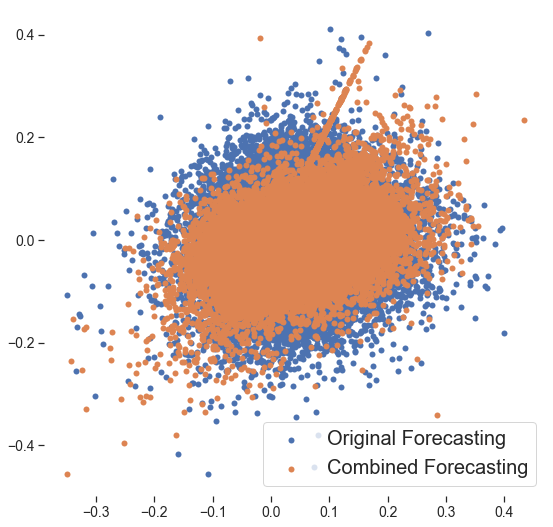

In [33]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(9, 9))

sns.despine(f, left=True, bottom=True)
sns.scatterplot(data=dt1, x='er1', y='er2', palette="ch:r=-.2,d=.3_r", linewidth=0, ax=ax)
sns.scatterplot(data=dt2, x='er1', y='er2', palette="ch:r=-.2,d=.3_r", linewidth=0, ax=ax)
plt.tick_params(axis='both', which='major', labelsize=14)

a = plt.xlabel('', fontsize=20)
a = plt.ylabel('', fontsize=20)
plt.legend(labels=['Original Forecasting','Combined Forecasting'], fontsize=20)

#f.savefig('combined_result_error_comparison_lead.png', dpi=1000, bbox_inches="tight")

### Comparison of the proposed method and the case when the generation forecasting is only adopted

In [34]:
gentoram = np.zeros(gen_pred.shape)

for i in range(gentoram.shape[0]):
    for j in range(gentoram.shape[1]):
        if j==0:
            if i==0:
                gen0 = gen_real[0,0]-ram_real[0,0]/100
            else:
                gen0 = gen_real[i-1,0]   
        else:
            gen0 = gen_pred[i,j-1]
            
        gentoram[i,j] = (gen_pred[i,j]-gen0)*100
        
gentoram = gentoram.reshape(-1,1)

In [35]:
gentoram = std_scaler_ramp.transform(gentoram)

In [36]:
print('Ramp Rate Only Error Test Score > MSE == ', mse(real_ram, ram_only), ' MAE == ', mae(real_ram, ram_only), 'MAPE == ', mape(real_ram, ram_only), ' MAEMS == ', maems(real_ram, ram_only))
print('Interpreted From Generation Forecasting Test Score > MSE == ', mse(real_ram, gentoram), ' MAE == ', mae(real_ram, gentoram), 'MAPE == ', mape(real_ram, gentoram), ' MAEMS == ', maems(real_ram, gentoram))
print('Combined Ramp Rate Error Test Score > MSE == ', mse(real_ram, com_ram), ' MAE == ', mae(real_ram, com_ram), 'MAPE == ', mape(real_ram, com_ram), ' MAEMS == ', maems(real_ram, com_ram))

Ramp Rate Only Error Test Score > MSE ==  0.005566241530721576  MAE ==  0.05821239682018539 MAPE ==  11.880816126680624  MAEMS ==  1.5878514991836474
Interpreted From Generation Forecasting Test Score > MSE ==  0.0059750358757484825  MAE ==  0.051400806971870924 MAPE ==  10.555255415397182  MAEMS ==  1.4008272813687404
Combined Ramp Rate Error Test Score > MSE ==  0.003351413010342231  MAE ==  0.04194306492762509 MAPE ==  8.61260187101693  MAEMS ==  1.1439627110891155


In [37]:
gentoram2 = gentoram[(real_ram>0.8)|(real_ram<0.2)]

In [38]:
print('Ramp Rate Only Error Test Score > MSE == ', mse(real_ram2, ram_only2), ' MAE == ', mae(real_ram2, ram_only2), 'MAPE == ', mape(real_ram2, ram_only2), ' MAEMS == ', maems(real_ram2, ram_only2))
print('Interpreted From Generation Forecasting Test Score > MSE == ', mse(real_ram2, gentoram2), ' MAE == ', mae(real_ram2, gentoram2), 'MAPE == ', mape(real_ram2, gentoram2), ' MAEMS == ', maems(real_ram2, gentoram2))
print('Combined Ramp Rate Error Test Score > MSE == ', mse(real_ram2, com_ram2), ' MAE == ', mae(real_ram2, com_ram2), 'MAPE == ', mape(real_ram2, com_ram2), ' MAEMS == ', maems(real_ram2, com_ram2))

Ramp Rate Only Error Test Score > MSE ==  0.011892261097147855  MAE ==  0.08684773201225526 MAPE ==  19.501992366448835  MAEMS ==  5.113642562705768
Interpreted From Generation Forecasting Test Score > MSE ==  0.014542142158926913  MAE ==  0.08815599580571952 MAPE ==  22.077382384154436  MAEMS ==  4.9636806788948125
Combined Ramp Rate Error Test Score > MSE ==  0.007432999345676252  MAE ==  0.06379176577335192 MAPE ==  15.501703517336319  MAEMS ==  3.6293392924914905
